# Detecting Depression with Machine Learning 

In the region of Lechi during the last five years, the rate of depression has drastically increased by a margin of 20%.
The regional government, concerned about this alarming situation, has decided to implement an early detection
program to help potential patients.
<br>In this assignment, you will use machine learning to predict the potential cases of depression in the region, by using
the data available in the registry office of Lechi.

In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

C:\Users\domenicoboris.salvat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1 - Data Preparation 
The dataset contains a list of inhabitants of the region with their respective data. It contains 15164 rows per 13 columns.
First let's import the _.csv_ file using pandas and assign it to a DataFrame named _dataset_. 

In [2]:
# Read CSV and print dataset shape
dataset = pd.read_csv('stress_train.csv')
print('stress_train.csv')
print(dataset.shape)
dataset.head()

stress_train.csv
(15164, 13)


,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,hours_week,country,permit,stress
0,43,Private,HS-grad,9,Divorced,Transport-moving,Not-in-family,NaN,Male,16,United-States,B,0
1,31,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Craft-repair,Husband,NaN,Male,40,United-States,D,0
2,47,Self-emp-not-inc,Some-college,10,Divorced,Exec-managerial,Not-in-family,NaN,Female,65,United-States,C,0
3,32,Private,HS-grad,9,Never-married,Sales,Own-child,NaN,Female,35,United-States,B,0
4,25,State-gov,Some-college,10,Divorced,Protective-serv,Other-relative,NaN,Male,45,United-States,A,0


## 2 - Data Exploration 
Using _Pandas_ method _.describe_ we can have a summary of the statistics of the variables contained in _dataset_, including categorical variables.<br>

In [3]:
# Statistics of X features matrix 
dataset.describe(include = 'all')

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,hours_week,country,permit,stress
count,15164.000000,14228,15164,15164.000000,15164,14224,15164,2328,15164,15164.000000,14901,15164,15164.000000
unique,NaN,8,16,NaN,5,14,6,4,2,NaN,40,5,NaN
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Adm-clerical,Husband,Black,Male,NaN,United-States,C,NaN
freq,NaN,10715,4890,NaN,6080,2197,4666,1596,7607,NaN,13596,3086,NaN
mean,38.211949,NaN,NaN,10.082036,NaN,NaN,NaN,NaN,NaN,39.496835,NaN,NaN,0.211817
std,13.769714,NaN,NaN,2.506576,NaN,NaN,NaN,NaN,NaN,12.407518,NaN,NaN,0.408610
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000
25%,27.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,36.000000,NaN,NaN,0.000000
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,0.000000
75%,47.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,0.000000


We see that there are four numerical variables, a binary _stress_ (outcome variable).<br> 
The average of the population is 38 years, with 10 years of education and about 40 working hours per week. The incidence of _stress_ (depression) is about 21%.<br>

## 2.1 - Handling Missing Values
Let's look at the numerosity of each variable and the presence of missing values : <br>
- The numerical variables _age_, _education_years_, _hours_week_ and categorical variables _education_, _marital_status_, _relationship_, _sex_ and _permit_ are complete.
- Categorical variables _workclass_, _occupation_, _race_ and _country_ have missing values. 
- In particular _race_ has much more missing data compared to others.

In [4]:
# 14228/15164 = 93%
# 2077/15164 = 13%

#### Cleaning data approach : 
In order to have a consistent dataset with complete information, without compromising the rapresentativity of the sample, we will approach to missing data problem in the following way : <br> 
_race_ has just 13% of observations compared to the dataset size. We could try to infer the _race_ from other variables but we will introduce multicollinearity among the data. Those synthetic points would be used later in the model to infer _stress_. In conclusion since _race_ has so few observations, it will be removed from dataset.<br>
Second step is to remove all the rows of the variables that have missing values.<br>
Droping "race" and rows with missing data allow us to work with more than 90% of the initial dataset, assuring the consistency of information.

In [5]:
# Step 1 : Drop 'race'
dataset.drop('race', axis = 1, inplace = True)
#dataset.describe(include = 'all')

In [6]:
# Step 2: Drop missing rows containing missing values
dataset.dropna(axis = 0, how = 'any', inplace = True)

Let's give a look the dataset cleaned :

In [7]:
print('Dataset cleaned after missing values :')
dataset.shape

Dataset cleaned after missing values :


(13977, 12)

This line to check the final numerosity being above 90% of the orginal data : 13977/15164 = 92% .

## 2.2 - Outliers
To have an idea of the distribution of the numerical variables and to reveal the presence of outliers, let's draw the boxplots with the pandas command _plot_ :

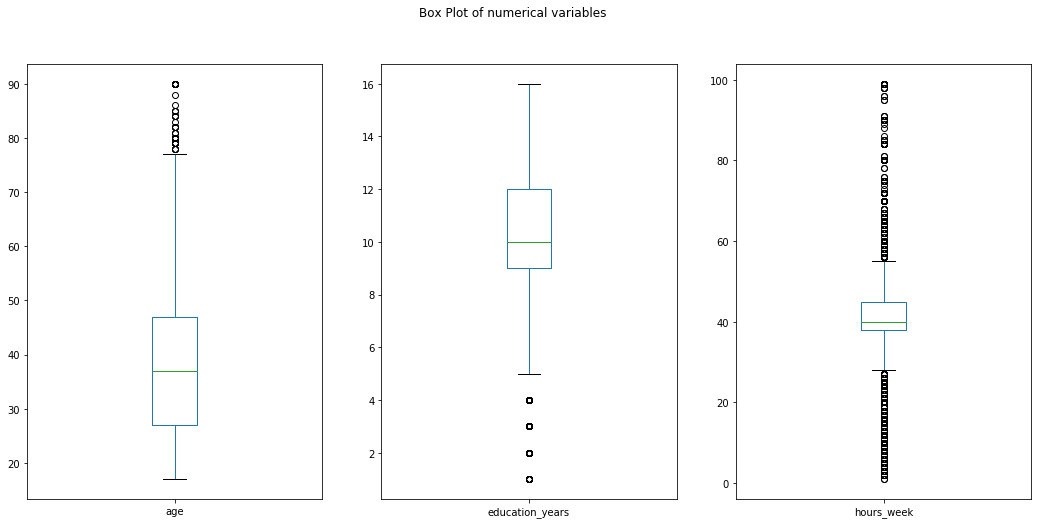

In [8]:
# Explorative analysis : boxplots
dataset[['age','education_years','hours_week']].plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(18,8), title='Box Plot of numerical variables')
plt.savefig('dataset_bp')
plt.show()

Box plots reveal the presence of outliers among the variables.<br>
With the following statement, let's count how many lies over 3 standard deviations from the mean :

In [9]:
# Detect the values which are over 3 standard deviations from the mean.
num_variables = ['age','education_years','hours_week']
for var in num_variables:
    print(var, " outliers : ", len(dataset[np.abs(dataset[var]-dataset[var].mean()) > (3*dataset[var].std())]))

age  outliers :  56
education_years  outliers :  75
hours_week  outliers :  174


Then let's remove the outliers using the *'Z-score'*. <br>
For each column of the dataset, first it computes the Z-score of each value, relative to the column mean and standard deviation. Then is taken the absolute of Z-score because the direction does not matter, only if it is below the threshold of 3 standard deviation. The method *.all(axis=1)* ensures that for each row, all column satisfy the constraint. 
<br><br>After removing the outliers, the dataset is pretty much the same size : from 13977 to 13675 observation.

In [10]:
dataset = dataset[(np.abs(stats.zscore(dataset[['age','education_years','hours_week']])) < 3).all(axis=1)]
print('Dataset cleaned after outliers :')
print(dataset.shape)


Dataset cleaned after outliers :
(13675, 12)


## 3 - Data Preparation

## 3.1 - Encoding Categorical variables
At this point we need to prepare the X feature matrix and encoding categorical variables. <br>
_One hot encoding_ will create dummy categorical variables and will add up to 83 features.

In [11]:
cat_columns = ['workclass','education','marital_status','occupation','relationship','sex','country','permit']

In [12]:
dataset_processed = pd.get_dummies(dataset, prefix_sep = '__',
                                    columns = cat_columns)

In [13]:
dataset_processed.shape

(13675, 97)

In [14]:
# Statistics
dataset_processed.describe()

,age,education_years,hours_week,stress,workclass__Federal-gov,workclass__Local-gov,workclass__Private,workclass__Self-emp-inc,workclass__Self-emp-not-inc,workclass__State-gov,...,country__Thailand,country__Trinadad&Tobago,country__United-States,country__Vietnam,country__Yugoslavia,permit__A,permit__B,permit__C,permit__D,permit__M
count,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,...,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.00000,13675.000000
mean,37.841463,10.162194,39.611408,0.219232,0.030713,0.073053,0.756782,0.030713,0.063327,0.045192,...,0.000658,0.000804,0.915905,0.002121,0.000512,0.193053,0.199269,0.202048,0.20117,0.204461
std,12.939459,2.413037,10.944015,0.413741,0.172545,0.260233,0.429041,0.172545,0.243560,0.207733,...,0.025647,0.028351,0.277540,0.046003,0.022620,0.394709,0.399465,0.401542,0.40089,0.403322
min,17.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,27.000000,9.000000,38.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,37.000000,10.000000,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,47.000000,12.000000,44.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,77.000000,16.000000,76.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [15]:
# X matrix and y vector definition : 
X = dataset_processed.drop('stress', axis = 1)
y = dataset_processed['stress']

## 3.2 - Train/Test split 

Let's create 4 splits for the original dataset : A Train setand a Test set split for X and y. The percentage of training / testing split is 75 to 25 :

In [17]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
print('Training set X')
print(np.shape(X_train))
print('and y')
print(np.shape(y_train))
print('Test set X')
print(np.shape(X_test))
print('and y')
print(np.shape(y_test))

Training set X
(10256, 96)
and y
(10256,)
Test set X
(3419, 96)
and y
(3419,)


## 3.3 Model Selection / Grid Search
For this assignment we will use a __Random Forest classifier__.<br>
Random Forest builds a series of parallel decision trees, each one trained on a subset of the original dataset. The split criteria is based on a random set of variables. Finally the results of the trees are pooled in order to get better performance.<br> Random Forest classifiers are robust to multicollinearity, so we can use the entire set of variables without reducing dimensionality. <br> <br>
Let's run a Gridsearch with 4 folds cross validation to find the hyperparameters for the model, optimized for the best F1 score :

In [19]:
# RANDOM FOREST 'rf'

classifier = RandomForestClassifier(random_state = 42)

parameters = {# resampling with or withut repcement
              'bootstrap': [True, False],
              # Maximum number of levels in tree
              'max_depth': [5, 10, 50, None],
              # Number of features to consider at every split
              'max_features': ['auto', 'sqrt'],
              # Minimum number of samples required at each leaf node
              'min_samples_leaf': [1, 2, 4],
              # Minimum number of samples required to split a node
              'min_samples_split': [2, 5, 10],
              # Number of trees in random forest
              'n_estimators': [10, 50, 100]}

gs_rf = GridSearchCV(classifier, parameters, cv = 4, scoring = 'f1', n_jobs = 20, verbose = 1, refit = True) 

gs_rf = gs_rf.fit(X_train,y_train)


Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   27.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   40.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 1728 out of 1728 | elapsed:  2.5min finished


In [20]:
#SUMMARIZE the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_rf.best_score_, gs_rf.best_params_))
means = gs_rf.cv_results_['mean_test_score']
stds = gs_rf.cv_results_['std_test_score']
params = gs_rf.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.615729 using {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


Let's save the model and evaluate its performance.

In [21]:
#SAVE BEST MODEL in the variable best_model
best_model_rf = gs_rf.best_estimator_
best_model_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Performance
The model gets a F1 score of 0.71 and 0.89 accuracy on training set.

In [22]:
# Training with Grid Search best model
y_hat = best_model_rf.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
print('Confusion Matrix')
print(cm)
tn = cm[0,0]
fn = cm[0,1]
fp = cm[1,0]
tp = cm[1,1] 
precision = tp/(tp+fp) 
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))
acc = np.sum(cm.diagonal()/np.sum(cm))
print('Best Model Training')
print('F1 =',f1,'\nAccuracy =',acc)

Confusion Matrix
[[7723  267]
 [ 616 1650]]
Best Model Training
F1 = 0.7889074826679416 
Accuracy = 0.9139040561622465


In [23]:
# Model Validation
y_hat_val = best_model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_hat_val)
print('Confusion Matrix')
print(cm)
tn = cm[0,0]
fn = cm[0,1]
fp = cm[1,0]
tp = cm[1,1] 
precision = tp/(tp+fp) 
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))
acc = np.sum(cm.diagonal()/np.sum(cm))
print('Best Model Validation')
print('F1 =',f1,'\nAccuracy =',acc)

Confusion Matrix
[[2501  186]
 [ 284  448]]
Best Model Validation
F1 = 0.6559297218155198 
Accuracy = 0.8625329043579995


#### Testing Performance
The model gets a F1 score of 0.6 and 0.845 accuracy on test set. 

## 4 - Import Validation Set

Let's now import the test set for validation and apply the same data processing.

In [24]:
# Read CSV and print dataset shape
test_set = pd.read_csv('stress_test.csv')
print('stress_test.csv')
print(test_set.shape)
test_set.head()

stress_test.csv
(6499, 12)


,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,hours_week,country,permit
0,44,Local-gov,Some-college,10,Divorced,Adm-clerical,Unmarried,NaN,Female,40,United-States,B
1,41,State-gov,Some-college,10,Divorced,Adm-clerical,Not-in-family,NaN,Female,40,United-States,C
2,39,Private,Some-college,10,Divorced,Adm-clerical,Unmarried,NaN,Female,45,United-States,B
3,24,Private,Masters,14,Never-married,Adm-clerical,Not-in-family,NaN,Male,56,United-States,B
4,36,Private,11th,7,Divorced,Sales,Not-in-family,NaN,Female,40,United-States,A


In [25]:
# Step 1 : Drop 'race'
test_set.drop('race', axis = 1, inplace = True)

In [30]:
test_set.describe(include = 'all')

,age,workclass,education,education_years,marital_status,occupation,relationship,sex,hours_week,country,permit
count,6499.000000,6091,6499,6499.000000,6499,6090,6499,6499,6499.000000,6401,6499
unique,NaN,8,16,NaN,5,14,6,2,NaN,40,5
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Adm-clerical,Husband,Male,NaN,United-States,C
freq,NaN,4546,2065,NaN,2663,951,2032,3285,NaN,5864,1368
mean,38.214341,NaN,NaN,10.036159,NaN,NaN,NaN,NaN,39.344361,NaN,NaN
std,13.702038,NaN,NaN,2.573885,NaN,NaN,NaN,NaN,12.319833,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
25%,27.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,37.000000,NaN,NaN
50%,36.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
75%,47.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,43.000000,NaN,NaN


In [26]:
# STEP 2 Get Dummy variables
test_set_processed = pd.get_dummies(test_set, prefix_sep = '__',
                                    columns = cat_columns)

In [27]:
# To check that input-output match same number of rows
test_set_processed.shape

(6499, 99)

Initial number of rows saved after data processing. However there is a different number of columns in train set and test set. This should be equal to apply the same model.

In [29]:
test_set_processed.describe(include = 'all')

,age,education_years,hours_week,workclass__Federal-gov,workclass__Local-gov,workclass__Never-worked,workclass__Private,workclass__Self-emp-inc,workclass__Self-emp-not-inc,workclass__State-gov,...,country__Thailand,country__Trinadad&Tobago,country__United-States,country__Vietnam,country__Yugoslavia,permit__A,permit__B,permit__C,permit__D,permit__M
count,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.00000,...,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000,6499.000000
mean,38.214341,10.036159,39.344361,0.030158,0.067241,0.000154,0.699492,0.027235,0.071703,0.04016,...,0.000615,0.000462,0.902293,0.002616,0.000769,0.189875,0.203570,0.210494,0.196184,0.199877
std,13.702038,2.573885,12.319833,0.171036,0.250458,0.012404,0.458514,0.162780,0.258016,0.19635,...,0.024803,0.021482,0.296941,0.051082,0.027729,0.392233,0.402684,0.407691,0.397140,0.399938
min,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,9.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,10.000000,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,12.000000,43.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
# TEST SET COLUMNS
test_set_cols = list(test_set_processed.columns.values)
print(len(test_set_cols))
test_set_cols

99


['age',
 'education_years',
 'hours_week',
 'workclass__Federal-gov',
 'workclass__Local-gov',
 'workclass__Never-worked',
 'workclass__Private',
 'workclass__Self-emp-inc',
 'workclass__Self-emp-not-inc',
 'workclass__State-gov',
 'workclass__Without-pay',
 'education__10th',
 'education__11th',
 'education__12th',
 'education__1st-4th',
 'education__5th-6th',
 'education__7th-8th',
 'education__9th',
 'education__Assoc-acdm',
 'education__Assoc-voc',
 'education__Bachelors',
 'education__Doctorate',
 'education__HS-grad',
 'education__Masters',
 'education__Preschool',
 'education__Prof-school',
 'education__Some-college',
 'marital_status__Divorced',
 'marital_status__Married-civ-spouse',
 'marital_status__Never-married',
 'marital_status__Separated',
 'marital_status__Widowed',
 'occupation__Adm-clerical',
 'occupation__Armed-Forces',
 'occupation__Craft-repair',
 'occupation__Exec-managerial',
 'occupation__Farming-fishing',
 'occupation__Handlers-cleaners',
 'occupation__Machine-

In [47]:
# TRAIN SET COLUMNS
train_set_cols = list(X.columns.values)
print(len(train_set_cols))
train_set_cols

96


['age',
 'education_years',
 'hours_week',
 'workclass__Federal-gov',
 'workclass__Local-gov',
 'workclass__Private',
 'workclass__Self-emp-inc',
 'workclass__Self-emp-not-inc',
 'workclass__State-gov',
 'workclass__Without-pay',
 'education__10th',
 'education__11th',
 'education__12th',
 'education__5th-6th',
 'education__7th-8th',
 'education__9th',
 'education__Assoc-acdm',
 'education__Assoc-voc',
 'education__Bachelors',
 'education__Doctorate',
 'education__HS-grad',
 'education__Masters',
 'education__Prof-school',
 'education__Some-college',
 'marital_status__Divorced',
 'marital_status__Married-civ-spouse',
 'marital_status__Never-married',
 'marital_status__Separated',
 'marital_status__Widowed',
 'occupation__Adm-clerical',
 'occupation__Armed-Forces',
 'occupation__Craft-repair',
 'occupation__Exec-managerial',
 'occupation__Farming-fishing',
 'occupation__Handlers-cleaners',
 'occupation__Machine-op-inspct',
 'occupation__Other-service',
 'occupation__Priv-house-serv',
 '

This are the differences, some extra dummy variable in TEST set should be removed, a missing country should be added (with all zero).

In [50]:
# Columns in TEST but not in TRAIN Set # should be dropped
cols_to_drop_from_test = (set(test_set_cols).difference(train_set_cols))
cols_to_drop_from_test

{'country__Holand-Netherlands',
 'education__1st-4th',
 'education__Preschool',
 'workclass__Never-worked'}

In [49]:
# Columns in TRAIN but not in TEST Set # should be added
(set(train_set_cols).difference(test_set_cols))

{'country__Honduras'}

In [53]:
# Drop extra dummies
test_set_processed.drop(cols_to_drop_from_test, axis = 1, inplace = True)

In [54]:
test_set_processed.shape

(6499, 95)

In [62]:
# Prepare missing column
country__Honduras = pd.DataFrame([0] * len(test_set_processed), columns =['country__Honduras'])
country__Honduras.shape

(6499, 1)

In [63]:
# Add missing column
test_set_processed['country__Honduras'] = country__Honduras

In [64]:
# Matching shape ok
test_set_processed.shape

(6499, 96)

In [67]:
# Prediction
target = best_model_rf.predict(test_set_processed)

6499

In [75]:
target_export = pd.DataFrame(target, columns = ['target'])
target_export

,target
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [77]:
target_export.to_csv('target.csv',sep=',')